# Models

## Imports and constants

In [12]:
from audiosep.data import load_data, split_data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [2]:
%load_ext autoreload
%autoreload 2

## Function to plot train / validation history

In [3]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

## Load data

In [4]:
inputs, targets = load_data()

# Baseline model- MLP

In [5]:
# split into train and test set
inputs_train, inputs_test, targets_train, targets_test =train_test_split(inputs,
                                                                         targets,
                                                                         test_size= 0.3)

In [6]:
# build network architecture
#len(np.unique(targets)) # number of targets, 9 genres in this case

def initialize_model():
    model = Sequential()
    penalty = regularizers.l2(0.001)

    # input layer
    model.add(Flatten(
        input_shape= (inputs.shape[1], inputs.shape[2])))
    
    # 1st hidden layer
    model.add(Dense(512, activation= "relu",
                    kernel_regularizer=penalty))
    model.add(Dropout(0.3))
    
    # 2nd hidden layer    
    model.add(Dense(256, activation= "relu",
                    kernel_regularizer=penalty))
    model.add(Dropout(0.3))
    
    # 3rd hidden layer
    model.add(Dense(64, activation= "relu",
                    kernel_regularizer=penalty))
    model.add(Dropout(0.3))
    
    # output layer
    model.add(Dense(9, activation= 'softmax'))
    
    # compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0003),
              metrics=['accuracy'])
    return model

In [7]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [8]:
# train network
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(inputs_train, targets_train,
              epochs= 150,
              batch_size= 32,
              validation_split=0.2,
              verbose=0,
              callbacks= [es]
             )

In [9]:
score = model.evaluate(inputs_test, targets_test)

85/85 [==============================] - 0s 2ms/step - loss: 1.3983 - accuracy: 0.5821


In [10]:
print(f'Validation loss:\t {score[0]}')
print(f'Validation Accuracy:\t {score[1]}')

Validation loss:	 1.3983043432235718
Validation Accuracy:	 0.5820674300193787


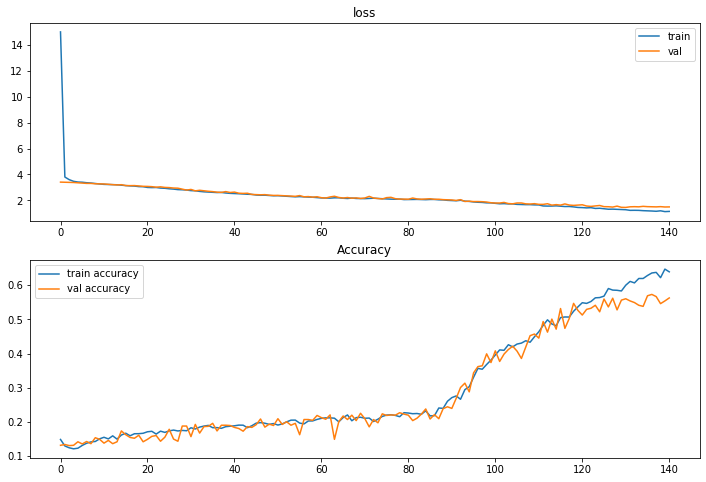

In [13]:
plot_history(history);

# CNN model

Initial CNN model defined. No parameter tuning.

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data()

In [15]:
def initialize_conv(input_shape):
    # create model
    model = Sequential()
    
    # 1st cond layer
    model.add(Conv2D(32, (3, 3), activation= 'relu', input_shape=input_shape))
    model.add(MaxPool2D((3, 3), strides= (2, 2), padding= 'same'))
    model.add(BatchNormalization())
    
    # 2nd conv layer
    model.add(Conv2D(32, (3, 3), activation= 'relu'))
    model.add(MaxPool2D((3, 3), strides= (2, 2), padding= 'same'))
    model.add(BatchNormalization())
    
    # 3rd conv layer
    model.add(Conv2D(32, (2, 2), activation= 'relu'))
    model.add(MaxPool2D((2, 2), strides= (2, 2), padding= 'same'))
    model.add(BatchNormalization())
    
    # flatten to 1D array and feed to dense
    model.add(Flatten())
    model.add(Dense(64, activation= 'relu'))
    model.add(Dropout(0.3))
    
    # output layer
    model.add(Dense(9, activation= 'softmax'))
    
    # compile model
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0003),
              metrics=['accuracy'])
    
    return model

In [16]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [17]:
cnn_model = initialize_conv(input_shape)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)        

In [18]:
es = EarlyStopping(patience=10, restore_best_weights=True)

history = cnn_model.fit(X_train, y_train,
                      epochs= 30,
                      batch_size= 32,
                      validation_data= (X_val, y_val),
                      verbose=2,
                      callbacks= [es])

Epoch 1/30
169/169 - 4s - loss: 1.9184 - accuracy: 0.3576 - val_loss: 1.5876 - val_accuracy: 0.4615
Epoch 2/30
169/169 - 4s - loss: 1.4452 - accuracy: 0.4869 - val_loss: 1.2324 - val_accuracy: 0.5385
Epoch 3/30
169/169 - 4s - loss: 1.2664 - accuracy: 0.5414 - val_loss: 1.0929 - val_accuracy: 0.5963
Epoch 4/30
169/169 - 4s - loss: 1.1383 - accuracy: 0.5964 - val_loss: 1.0338 - val_accuracy: 0.6252
Epoch 5/30
169/169 - 4s - loss: 1.0479 - accuracy: 0.6253 - val_loss: 0.9668 - val_accuracy: 0.6504
Epoch 6/30
169/169 - 4s - loss: 0.9642 - accuracy: 0.6602 - val_loss: 0.9096 - val_accuracy: 0.6615
Epoch 7/30
169/169 - 4s - loss: 0.9122 - accuracy: 0.6798 - val_loss: 0.9282 - val_accuracy: 0.6644
Epoch 8/30
169/169 - 4s - loss: 0.8447 - accuracy: 0.7047 - val_loss: 0.8485 - val_accuracy: 0.7030
Epoch 9/30
169/169 - 4s - loss: 0.7911 - accuracy: 0.7280 - val_loss: 0.8520 - val_accuracy: 0.7059
Epoch 10/30
169/169 - 4s - loss: 0.7462 - accuracy: 0.7417 - val_loss: 0.8184 - val_accuracy: 0.7200

(<matplotlib.axes._subplots.AxesSubplot at 0x17016f96f48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1701707ed08>)

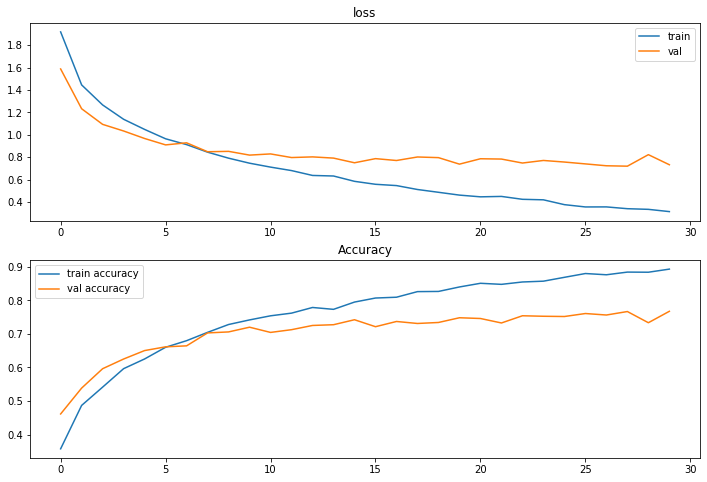

In [19]:
plot_history(history)

In [20]:
cnn_model.evaluate(X_test, y_test)

71/71 [==============================] - 0s 5ms/step - loss: 0.7318 - accuracy: 0.7577


[0.7317885756492615, 0.7576701045036316]

## Inference From CNN

In [24]:
def predict(model, X, y):
    # reshape X
    X = X[np.newaxis, ...] # to match model input shape
    
    # get predictions
    pred = model.predict(X) # pred is 2D array of probs for each genre class
    
    # extract index with max val
    pred = np.argmax(pred, axis=1)[0]
    
    # gotten from data.json['mapping']
    genres ={0: "blues",
         1: "classical",
         2: "country",
         3: "disco",
         4: "hiphop",
         5: "metal",
         6: "pop",
         7: "reggae",
         8: "rock"
        }
    if y == pred:
        print(f"Expected genre: {genres.get(y)}\tPredicted genre: {genres.get(pred)}\t CORRECT")
    else:
        print(f"Expected genre: {genres.get(y)}\tPredicted genre: {genres.get(pred)}\t WRONG")

Testing random predictions from test set

In [27]:
for _ in range(15):
    i = np.random.randint(low=1, high=2249)
    predict(cnn_model, X_test[i], y_test[i])

Expected genre: reggae	Predicted genre: reggae	 CORRECT
Expected genre: pop	Predicted genre: pop	 CORRECT
Expected genre: country	Predicted genre: country	 CORRECT
Expected genre: reggae	Predicted genre: hiphop	 WRONG
Expected genre: rock	Predicted genre: rock	 CORRECT
Expected genre: classical	Predicted genre: classical	 CORRECT
Expected genre: disco	Predicted genre: disco	 CORRECT
Expected genre: pop	Predicted genre: hiphop	 WRONG
Expected genre: rock	Predicted genre: metal	 WRONG
Expected genre: country	Predicted genre: country	 CORRECT
Expected genre: rock	Predicted genre: rock	 CORRECT
Expected genre: reggae	Predicted genre: reggae	 CORRECT
Expected genre: disco	Predicted genre: disco	 CORRECT
Expected genre: reggae	Predicted genre: reggae	 CORRECT
Expected genre: country	Predicted genre: country	 CORRECT
